# Auto Parts Siamese Network Training

This notebook contains the complete training pipeline with debugging and visualization tools.

In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Add project root to path
project_root = str(Path.cwd().parent)
sys.path.append(project_root)

from src.model import SiameseNetwork
from src.dataset import AutoPartsDataset, TripletLoss
from src.config import Config

## 1. Configuration and Setup

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Initialize config
config = Config()

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## 2. Data Loading and Exploration

In [3]:
# Explore the dataset

train_dataset = AutoPartsDataset(config.train_dir)
val_dataset = AutoPartsDataset(config.val_dir)

print(f'Total training samples: {len(train_dataset)}')
print(f'Total validation samples: {len(val_dataset)}')


Total training samples: 19280
Total validation samples: 400


## 3. Visualize Sample Pairs

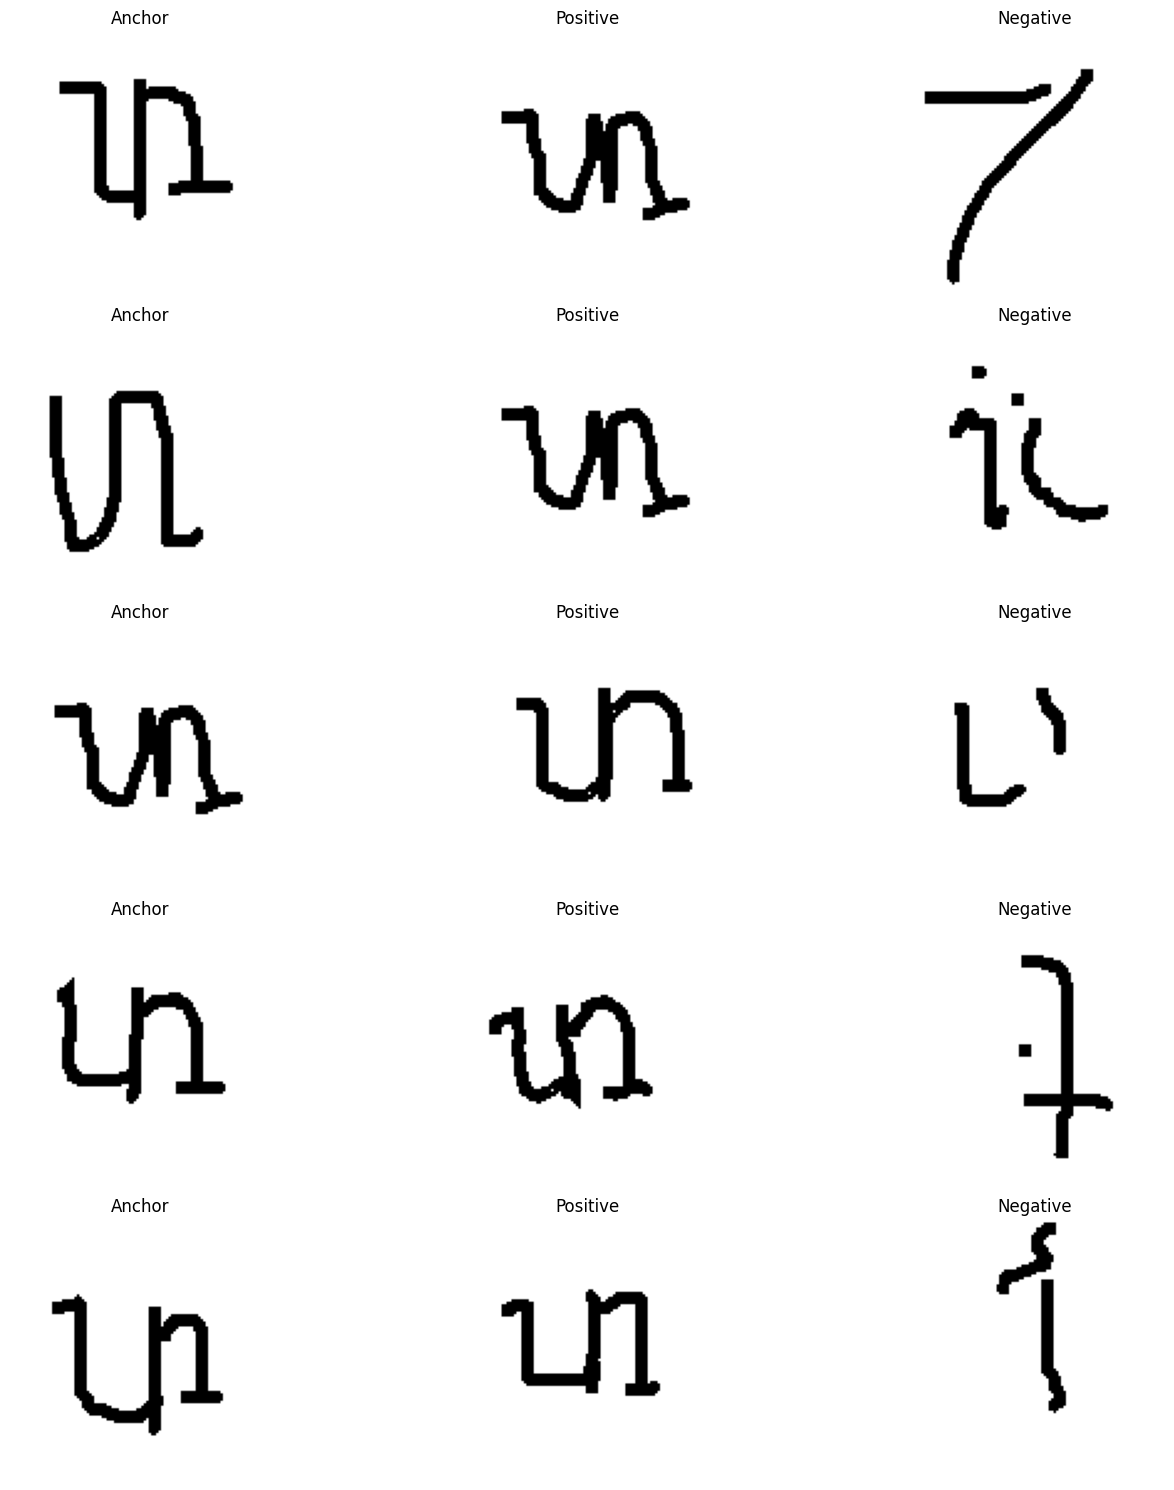

In [4]:
def show_triplets(dataset, num_triplets=5):
    """Visualize sample triplets (anchor, positive, negative) from dataset"""
    fig, axes = plt.subplots(num_triplets, 3, figsize=(15, num_triplets * 3))
    
    for i in range(num_triplets):
        anchor_img, positive_img, negative_img = dataset[i]
        
        # Denormalize images
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        anchor_img = anchor_img * std + mean
        positive_img = positive_img * std + mean
        negative_img = negative_img * std + mean
        
        axes[i, 0].imshow(anchor_img.permute(1, 2, 0).clip(0, 1))
        axes[i, 1].imshow(positive_img.permute(1, 2, 0).clip(0, 1))
        axes[i, 2].imshow(negative_img.permute(1, 2, 0).clip(0, 1))
        
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
        axes[i, 2].axis('off')
        
        axes[i, 0].set_title("Anchor")
        axes[i, 1].set_title("Positive")
        axes[i, 2].set_title("Negative")
    
    plt.tight_layout()
    plt.show()

# Call the function to visualize triplets
show_triplets(train_dataset)



## 4. Model Setup and Training Functions

In [5]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    total_batches = len(train_loader)
    
    with tqdm(train_loader, desc='Training', total=total_batches) as pbar:
        for batch_idx, (anchor, positive, negative) in enumerate(pbar):
            # Move data to device
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            
            # Forward pass
            anchor_out, positive_out, negative_out = model(anchor, positive, negative)
            
            # Calculate loss
            loss = criterion(anchor_out, positive_out, negative_out)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update running loss
            running_loss += loss.item()
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'avg_loss': f'{running_loss / (batch_idx + 1):.4f}'
            })
    
    return running_loss / total_batches

def validate(model, val_loader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    total_batches = len(val_loader)
    
    with torch.no_grad():
        with tqdm(val_loader, desc='Validating', total=total_batches) as pbar:
            for batch_idx, (anchor, positive, negative) in enumerate(pbar):
                # Move data to device
                anchor = anchor.to(device)
                positive = positive.to(device)
                negative = negative.to(device)
                
                # Forward pass
                anchor_out, positive_out, negative_out = model(anchor, positive, negative)
                
                # Calculate loss
                loss = criterion(anchor_out, positive_out, negative_out)
                
                # Update running loss
                running_loss += loss.item()
                
                # Update progress bar
                pbar.set_postfix({
                    'val_loss': f'{loss.item():.4f}',
                    'avg_val_loss': f'{running_loss / (batch_idx + 1):.4f}'
                })
    
    return running_loss / total_batches

## 5. Initialize Model and Training Components

In [6]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, 
                         shuffle=True, num_workers=config.num_workers)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size,
                       shuffle=False, num_workers=config.num_workers)

# Initialize model
model = SiameseNetwork(embedding_dim=config.embedding_dim).to(device)

# Loss and optimizer
criterion = TripletLoss()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=5, verbose=True
)

/home/james/MyFolder/code/GIT/WCP_siamese_parts_rec/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 6. Training Loop with Monitoring

In [7]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0

# Training loop
best_val_loss = float('inf')
early_stopping_counter = 0

for epoch in range(config.num_epochs):
    print(f'\nEpoch {epoch + 1}/{config.num_epochs}')
    
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    print(f'Training Loss: {train_loss:.4f}')
    
    # Validate
    val_loss = validate(model, val_loader, criterion, device)
    print(f'Validation Loss: {val_loss:.4f}')
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        
        # Save model
        model_save_path = config.model_save_path
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'train_loss': train_loss,
        }, model_save_path)
        print(f'Saved new best model to {model_save_path}')
    else:
        early_stopping_counter += 1
        
    # Early stopping
    if early_stopping_counter >= 10:
        print(f'Early stopping triggered after {epoch + 1} epochs')
        break
        
print('Training completed!')
print(f'Best validation loss: {best_val_loss:.4f}')


Epoch 1/50


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Training Loss: 0.7984


Validating:   0%|          | 0/25 [00:00<?, ?it/s]

Validation Loss: 0.6988
Saved new best model to models/2024-12-22_siamese.pth

Epoch 2/50


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Training Loss: 0.7325


Validating:   0%|          | 0/25 [00:00<?, ?it/s]

Validation Loss: 0.5696
Saved new best model to models/2024-12-22_siamese.pth

Epoch 3/50


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Training Loss: 0.7119


Validating:   0%|          | 0/25 [00:00<?, ?it/s]

Validation Loss: 0.6491

Epoch 4/50


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Training Loss: 0.7118


Validating:   0%|          | 0/25 [00:00<?, ?it/s]

Validation Loss: 0.6985

Epoch 5/50


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Training Loss: 0.7012


Validating:   0%|          | 0/25 [00:00<?, ?it/s]

Validation Loss: 0.5372
Saved new best model to models/2024-12-22_siamese.pth

Epoch 6/50


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

Training Loss: 0.6923


Validating:   0%|          | 0/25 [00:00<?, ?it/s]

Validation Loss: 0.5938

Epoch 7/50


Training:   0%|          | 0/1205 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 7. Analyze Training Results

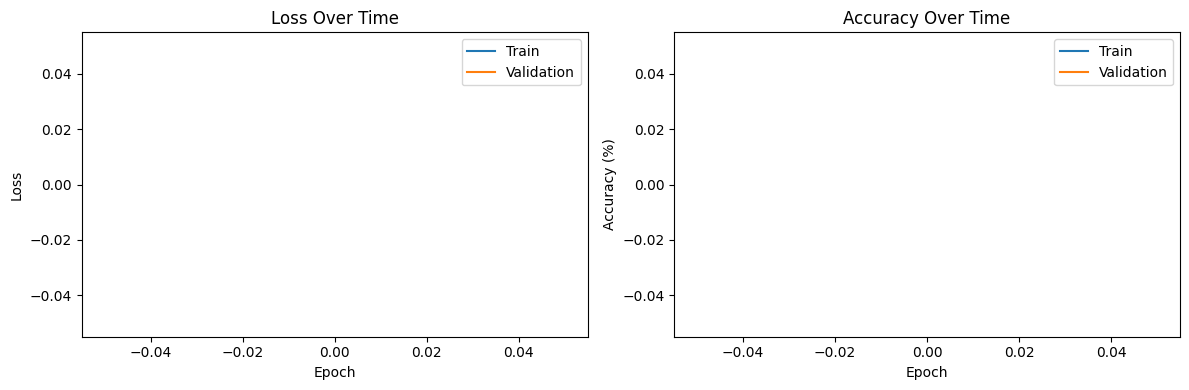

In [8]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

## 8. Model Evaluation and Error Analysis